#### Importing necessary Libraries

In [25]:
# !unzip /content/creditcard.csv.zip

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import make_scorer,f1_score,r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, log_loss, accuracy_score,roc_curve
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.preprocessing import binarize, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore')
%matplotlib inline

In [27]:
# import pandas as pd
# from sklearn.model_selection import train_test_split

# # Đọc file CSV gốc
# file_path = '/content/creditcard.csv'
# data = pd.read_csv(file_path)

# # Chia dữ liệu thành hai phần theo tỷ lệ 9:1
# train_data, test_data = train_test_split(data, test_size=0.1, random_state=42)

# # Lưu hai phần dữ liệu vào hai file CSV riêng biệt
# train_data.to_csv('creditcard_train_data.csv', index=False)
# test_data.to_csv('creditcard_test_data.csv', index=False)


#### Tạo các hàm đang được sử dụng nhiều lần

In [28]:
# định nghĩa một hàm để in số đo độ chính xác
def print_accuracy_metrics(Input,Output):
  print("Recall:", recall_score(Input, Output))
  print("Log Loss:", log_loss(Input, Output))
  print("Precision:", precision_score(Input, Output))
  print("Accurcay:", accuracy_score(Input, Output))
  print("AUC: ", roc_auc_score(Input, Output))
  print("F1 Score:", f1_score(Input, Output))
  confusion_matrix_value = confusion_matrix(Input,Output)
  print('Confusion matrix:\n', confusion_matrix_value)
  class_names=[0,1] # name  of classes
  fig, ax = plt.subplots()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names)
  plt.yticks(tick_marks, class_names)
  # create heatmap
  sns.heatmap(pd.DataFrame( confusion_matrix_value), annot=True, cmap="YlGnBu" ,fmt='g')
  ax.xaxis.set_label_position("top")
  plt.tight_layout()
  plt.title('Confusion matrix', y=1.1)
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')


In [29]:
# định nghĩa một hàm để in điểm xác thực chéo
scoring = {'recall' : make_scorer(recall_score)}
def cross_validation_metrics(log_reg, X, y):
 log_reg_score = cross_val_score(log_reg, X,y,cv=5,scoring='recall')
 print('Logistic Regression Cross Validation Score(Recall): ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')

In [30]:
# hàm để vẽ đồ thị tầm quan trọng của đặc điểm
def feature_importance(model, X):
  importances = model.feature_importances_
  std = np.std([tree.feature_importances_ for tree in model.estimators_],
               axis=0)
  indices = np.argsort(importances)[::-1]

  # In xếp hạng tính năng
  print("Feature ranking:")

  for f in range(X.shape[1]):
      print("%d. %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

  # Vẽ sơ đồ tầm quan trọng của đặc điểm rừng
  plt.figure()
  plt.title("Feature importances")
  plt.bar(range(X.shape[1]), importances[indices],
          color="r", yerr=std[indices], align="center")
  plt.xticks(range(X.shape[1]), indices)
  plt.xlim([-1, X.shape[1]])
  plt.show()

In [31]:
# function to draw ROC curve
def plot_auc_curve(model,y, y_pred_prob):
  auc = roc_auc_score(y, y_pred_prob)
  fpr, tpr, thresholds = roc_curve(y, y_pred_prob)

  plt.plot(fpr, tpr)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.title('ROC Curve\n AUC={auc}'.format(auc = auc))
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.grid(True)

In [32]:
### Reading data as a pandas dataframe
data = pd.read_csv('creditcard.csv')

#### Data Exploration

In [33]:
#### Exploring data set
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [34]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


#### Quan sát

In [35]:
data.shape

(284807, 31)

In [36]:
data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [37]:
#### Kiểm tra giá trị null trong tập dữ liệu
data.isnull().sum().max()

0

###### Dữ liệu khá sạch và không có id trùng lặp nào, hãy kiểm tra phân phối của từng tính năng

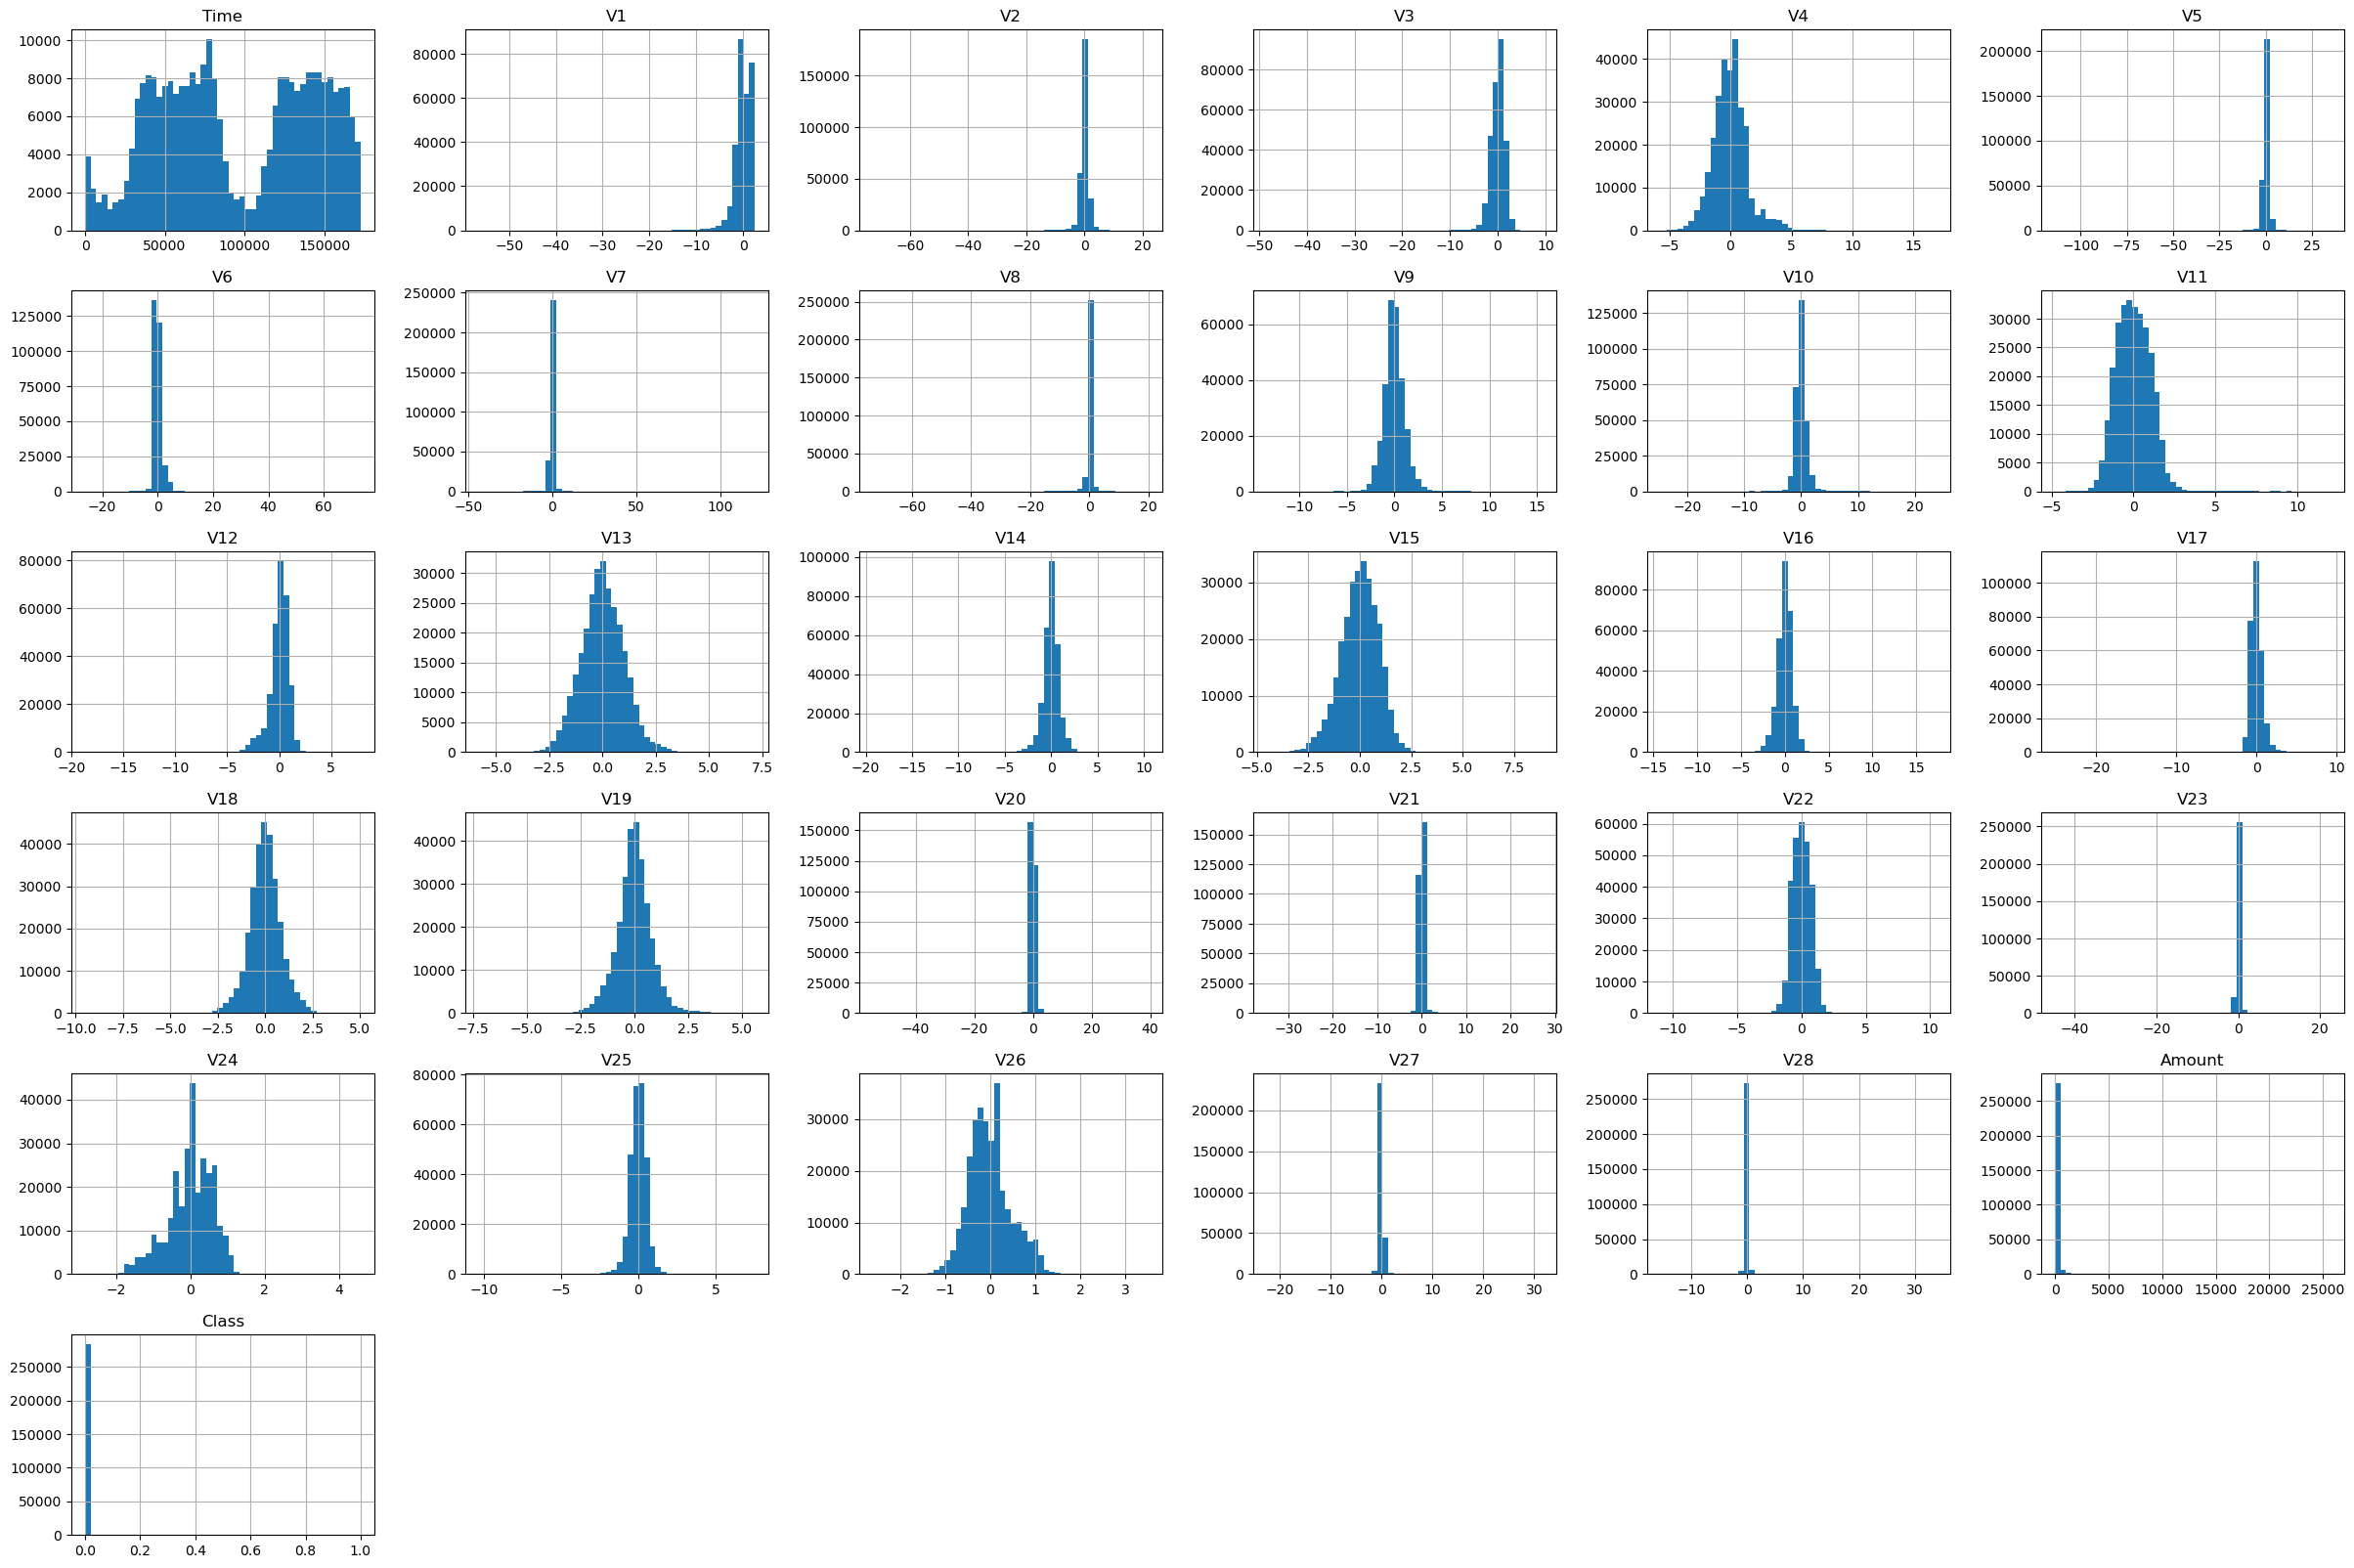

In [38]:
# Plot the histograms of each
data.hist(bins=50, figsize=(30,20))
plt.show()

##### Chúng ta có thể quan sát thấy rằng tất cả các tính năng trong tập dữ liệu đều được chia tỷ lệ ngoại trừ số lượng và thời gian.
##### Vì vậy, trong bước tiếp theo, tôi sẽ chia tỷ lệ cột Số tiền trong tập dữ liệu và xóa cột thời gian.

In [39]:
data['normal_amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1,1))
data = data.drop(['Amount','Time'], axis=1)
X = data.loc[:,data.columns != 'Class']
y = data.loc[:,data.columns == 'Class']

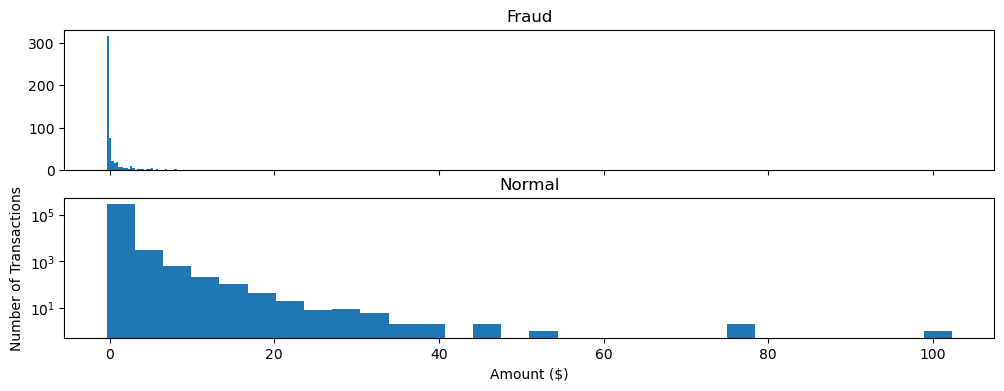

In [40]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))

bins = 30

ax1.hist(data.normal_amount[data.Class == 1], bins = bins)
ax1.set_title('Fraud')

ax2.hist(data.normal_amount[data.Class == 0], bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.yscale('log')
plt.show()

##### Chúng ta có thể quan sát từ hình trên rằng số lượng giao dịch gian lận là rất ít.
##### Trong bước tiếp theo, tôi sẽ hình dung số lượng giao dịch gian lận và số lượng giao dịch Không gian lận.

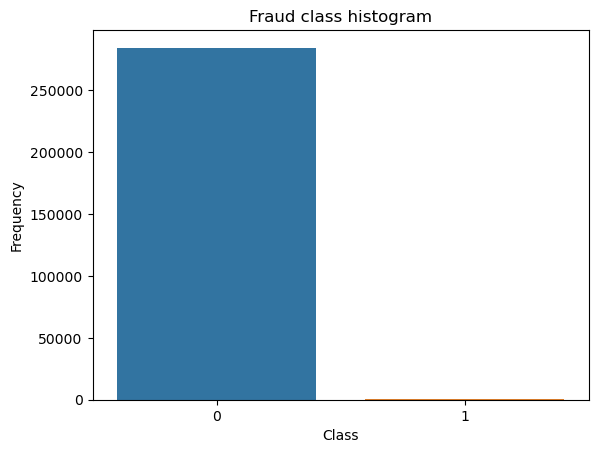

In [41]:
# Bây giờ hãy kiểm tra sự phân bố của lớp
# sns.countplot(x="Class", data=data, pallet={'0': 'green', '1': 'red'})
sns.countplot(x="Class", data=data)

plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

##### Như bạn có thể quan sát từ biểu đồ, chúng ta có rất nhiều số 0 (không gian lận) so với 1 (lừa đảo).
##### Kiểu mất cân bằng này trong biến mục tiêu được gọi là mất cân bằng lớp.

In [42]:
# Showing ratio
print("Percentage of normal transactions: ", len(data[data.Class == 0])/len(data))
print("Percentage of fraud transactions: ", len(data[data.Class == 1])/len(data))
print("Total number of transactions in data: ", len(data))

Percentage of normal transactions:  0.9982725143693799
Percentage of fraud transactions:  0.001727485630620034
Total number of transactions in data:  284807


##### Hầu hết các giao dịch đều không gian lận (99,83%) vào thời điểm đó,
##### trong khi giao dịch Gian lận xảy ra 0,17% thời gian trong khung dữ liệu.

#### Tách tập dữ liệu gốc thành thử nghiệm và huấn luyện

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 0)

### 1] Logistic regression on imbalanced dataset

In [44]:
lr = LogisticRegression()
lr.fit(X_train,y_train)

LogisticRegression()

Logistic Regression Cross Validation Score(Recall):  61.74%
Recall: 0.6190476190476191
Log Loss: 0.028685421046311402
Precision: 0.883495145631068
Accurcay: 0.999204147794436
AUC:  0.8094534662486266
F1 Score: 0.728
Confusion matrix:
 [[85284    12]
 [   56    91]]


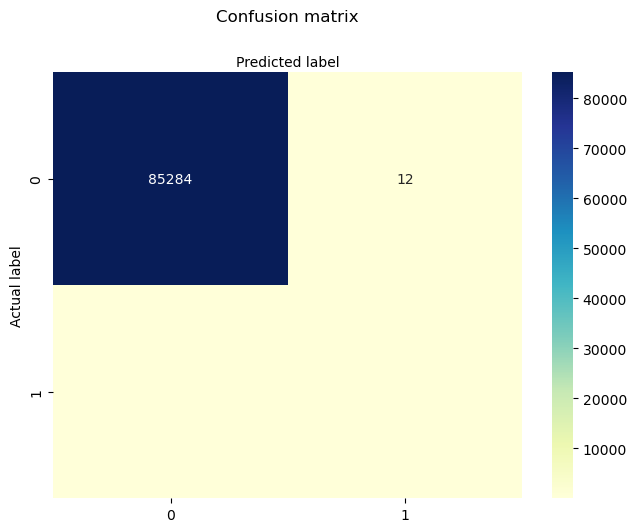

In [45]:
# Accuracy metrics for
y_pred = lr.predict(X_test)
cross_validation_metrics(lr,X_train,y_train)
print_accuracy_metrics(y_test,y_pred)

##### Observatios
Bằng cách quan sát độ chính xác, chúng tôi có thể kết luận rằng thuật toán đang hoạt động rất tốt. Nhưng điều đó không đúng. Vì hầu hết các nhãn 0, ngay cả việc đoán ngẫu nhiên cũng mang lại cho bạn độ chính xác 99%. Vì vậy, chúng ta cần một thước đo tốt hơn để hiểu hiệu suất của mô hình.

##### Recall
Recall là thước đo đo lường khả năng dự đoán đúng của mô hình đối với một nhãn nhất định. Trong trường hợp của chúng tôi, chúng tôi muốn kiểm tra xem mô hình có thể nhớ lại các trường hợp gian lận chính xác đến mức nào vì chúng tôi quan tâm đến điều đó.
Như bạn có thể quan sát từ kết quả, tỷ lệ thu hồi đối với 1.0 chỉ là 0,6016 so với 99% đối với 0. Vì vậy, mô hình của chúng tôi không làm tốt công việc phát hiện gian lận. Vì vậy, điều này cho thấy dữ liệu mất cân bằng ảnh hưởng như thế nào đến độ chính xác của mô hình.

### 2]  Using Class Weight (Logistic regression)
Scikit-learn logistic regression có một tùy chọn có tên class_weight khi được chỉ định sẽ xử lý sự mất cân bằng lớp một cách ngầm định. Vì vậy, cố gắng dự đoán bằng kỹ thuật này

In [46]:
lr_balanced = LogisticRegression(class_weight = 'balanced')
lr_balanced.fit(X_train,y_train)

LogisticRegression(class_weight='balanced')

Logistic Regression Cross Validation Score(Recall):  89.86%
Recall: 0.9115646258503401
Log Loss: 0.8230184773728403
Precision: 0.06467181467181467
Accurcay: 0.9771660639256581
AUC:  0.9444218739831329
F1 Score: 0.12077512392969804
Confusion matrix:
 [[83358  1938]
 [   13   134]]


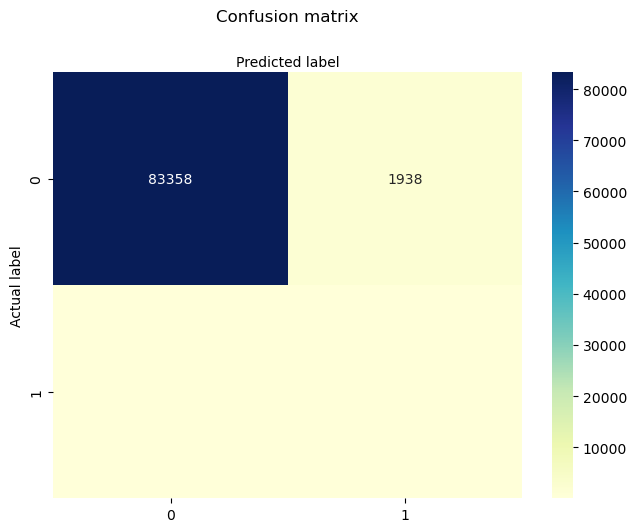

In [47]:
y_balanced_pred = lr_balanced.predict(X_test)
cross_validation_metrics(lr_balanced,X_train,y_train)
print_accuracy_metrics(y_test,y_balanced_pred)

In [48]:
y_balanced_pred_prob = lr_balanced.predict_proba(X_test)[:, 1]

In [49]:
print('Prob:', y_balanced_pred_prob[0:20])

Prob: [0.11787737 0.10846437 0.16225886 0.04103306 0.06945814 0.80536086
 0.33631759 0.01522809 0.01659318 0.45299479 0.03836546 0.02968987
 0.0013642  0.00311836 0.00773784 0.05655792 0.01762419 0.00896546
 0.09345336 0.0514922 ]


In [50]:
print('Prob:', y_balanced_pred[0:20])

Prob: [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


##### Undersampling of the dataset
Undersampling là một trong những kỹ thuật được sử dụng để xử lý sự mất cân bằng của lớp.
Trong kỹ thuật này, chúng ta lấy mẫu lớp đa số để phù hợp với lớp thiểu số.
Vì vậy, trong ví dụ của chúng tôi, chúng tôi lấy mẫu ngẫu nhiên của lớp không gian lận để khớp với số lượng mẫu gian lận.
Điều này đảm bảo rằng dữ liệu đào tạo có số lượng mẫu gian lận và không gian lận bằng nhau.

In [51]:
number_records_fraud = len(data[data.Class == 1])
fraud_indices = np.array(data[data.Class == 1].index)

In [52]:
normal_indices = data[data.Class == 0].index

In [53]:
random_normal_indices = np.random.choice(normal_indices, number_records_fraud, replace = False)
random_normal_indices = np.array(random_normal_indices)

In [54]:
under_sample_indices = np.concatenate([fraud_indices,random_normal_indices])

In [55]:
under_sample = data.iloc[under_sample_indices,:]

In [56]:
under_sample.shape

(984, 30)

Vì vậy, có tổng số 844 quan sát trong khung dữ liệu mẫu dưới của chúng tôi.
##### Hiển thị dữ liệu chưa được lấy mẫu

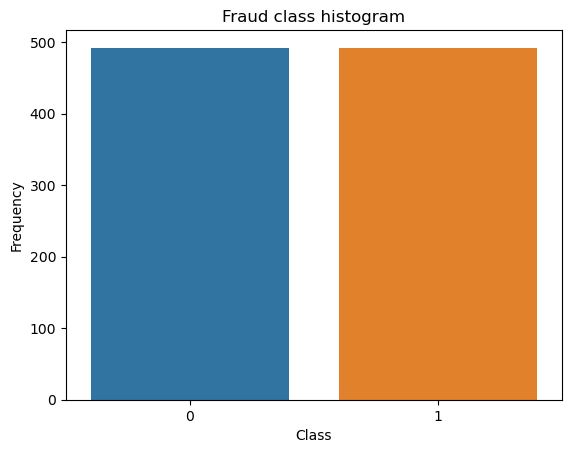

In [58]:
sns.countplot(x="Class", data=under_sample)
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()


##### Trong biểu đồ trên, bạn có thể quan sát thấy các lớp hiện được phân bổ đều.

Nếu chúng ta cố gắng tương quan giữa lớp và các tính năng trên tập dữ liệu không cân bằng thì nó sẽ vô ích vì chúng ta sẽ không thấy mối tương quan thực sự giữa các tính năng với kết quả. Trong khi bây giờ tôi sẽ xem các tính năng và lớp w.r.t tương quan của chúng trên khung dữ liệu chưa được lấy mẫu.

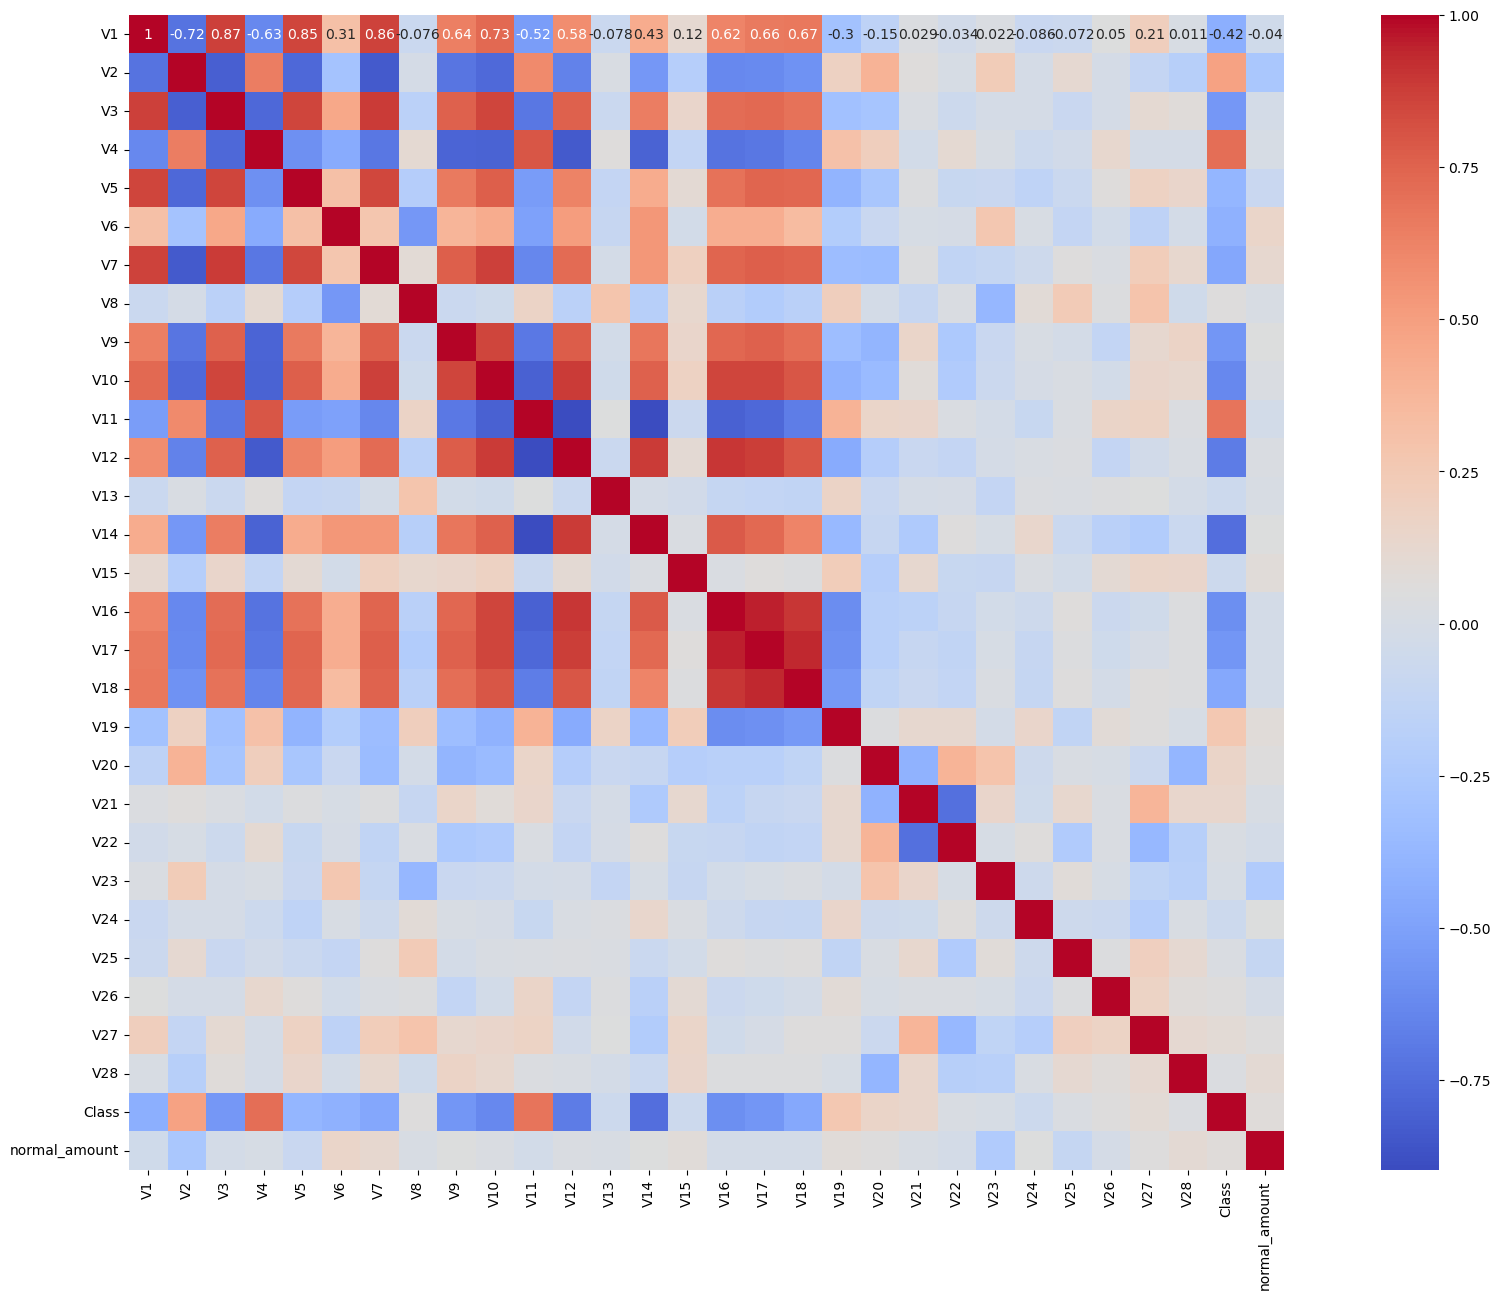

In [59]:
# Tạo ma trận tương quan
corrmat = under_sample.corr()

# Tạo biểu đồ heatmap
fig, ax = plt.subplots()
fig.set_size_inches(25, 15)
sns.heatmap(corrmat, square=True, annot=True, cmap='coolwarm', ax=ax)

# Lưu biểu đồ dưới dạng file ảnh
plt.savefig('correlation_matrix_heatmap.png')

# Hiển thị biểu đồ
plt.show()

In [60]:
X_under = under_sample.loc[:,under_sample.columns != 'Class']
y_under = under_sample.loc[:,under_sample.columns == 'Class']
X_under_train, X_under_test, y_under_train, y_under_test = train_test_split(X_under,y_under,test_size = 0.3, random_state = 0)

In [61]:
rf = RandomForestClassifier(n_estimators=100,
                            criterion='gini',
                            max_features='sqrt',
                            n_jobs=-1)
rf.fit(X_under_train, y_under_train)

RandomForestClassifier(n_jobs=-1)

Feature ranking:
1. V14 (0.192972)
2. V10 (0.149806)
3. V12 (0.119219)
4. V17 (0.102512)
5. V4 (0.072403)
6. V11 (0.047104)
7. V3 (0.041876)
8. V7 (0.039752)
9. V16 (0.027548)
10. V9 (0.024514)
11. V21 (0.021187)
12. V2 (0.018844)
13. V8 (0.016779)
14. V20 (0.012879)
15. V1 (0.010394)
16. V19 (0.010025)
17. V13 (0.009383)
18. normal_amount (0.008962)
19. V26 (0.008317)
20. V15 (0.008263)
21. V27 (0.008057)
22. V22 (0.007362)
23. V23 (0.007302)
24. V18 (0.006952)
25. V25 (0.006437)
26. V6 (0.006235)
27. V24 (0.005305)
28. V5 (0.005206)
29. V28 (0.004405)


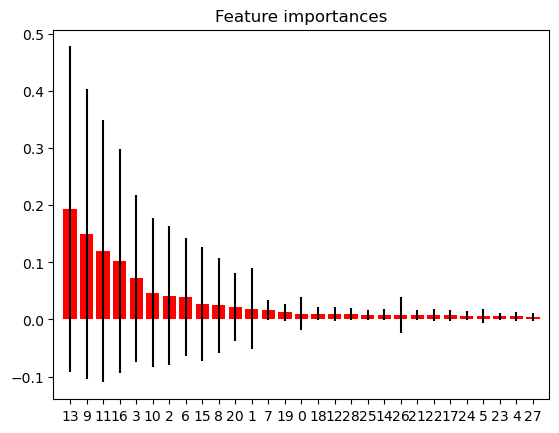

In [62]:
feature_importance(rf,X_under_train)

##### Từ sơ đồ nhiệt ở trên, chúng ta có thể nói rằng nhiều tính năng có mối tương quan với nhau nhưng chúng tôi quan tâm nhiều hơn đến mối tương quan giữa các tính năng với lớp. Vì vậy, tôi sẽ liệt kê những tính năng có hệ số tương quan lớp w.r.t nhỏ hơn -0,6 hoặc lớn hơn 0,6

In [63]:

corr = under_sample.corr()
corr = corr[['Class']]
corr[corr.Class < -0.6]

,Class
V10,-0.623881
V12,-0.684855
V14,-0.744188


In [64]:

corr[corr.Class > 0.6]

,Class
V4,0.706461
V11,0.681551
Class,1.000000


##### BoxPlots
Chúng tôi sẽ sử dụng boxplots để hiểu rõ hơn về sự phân bố của các đặc điểm này trong các giao dịch gian lận và không gian lận.

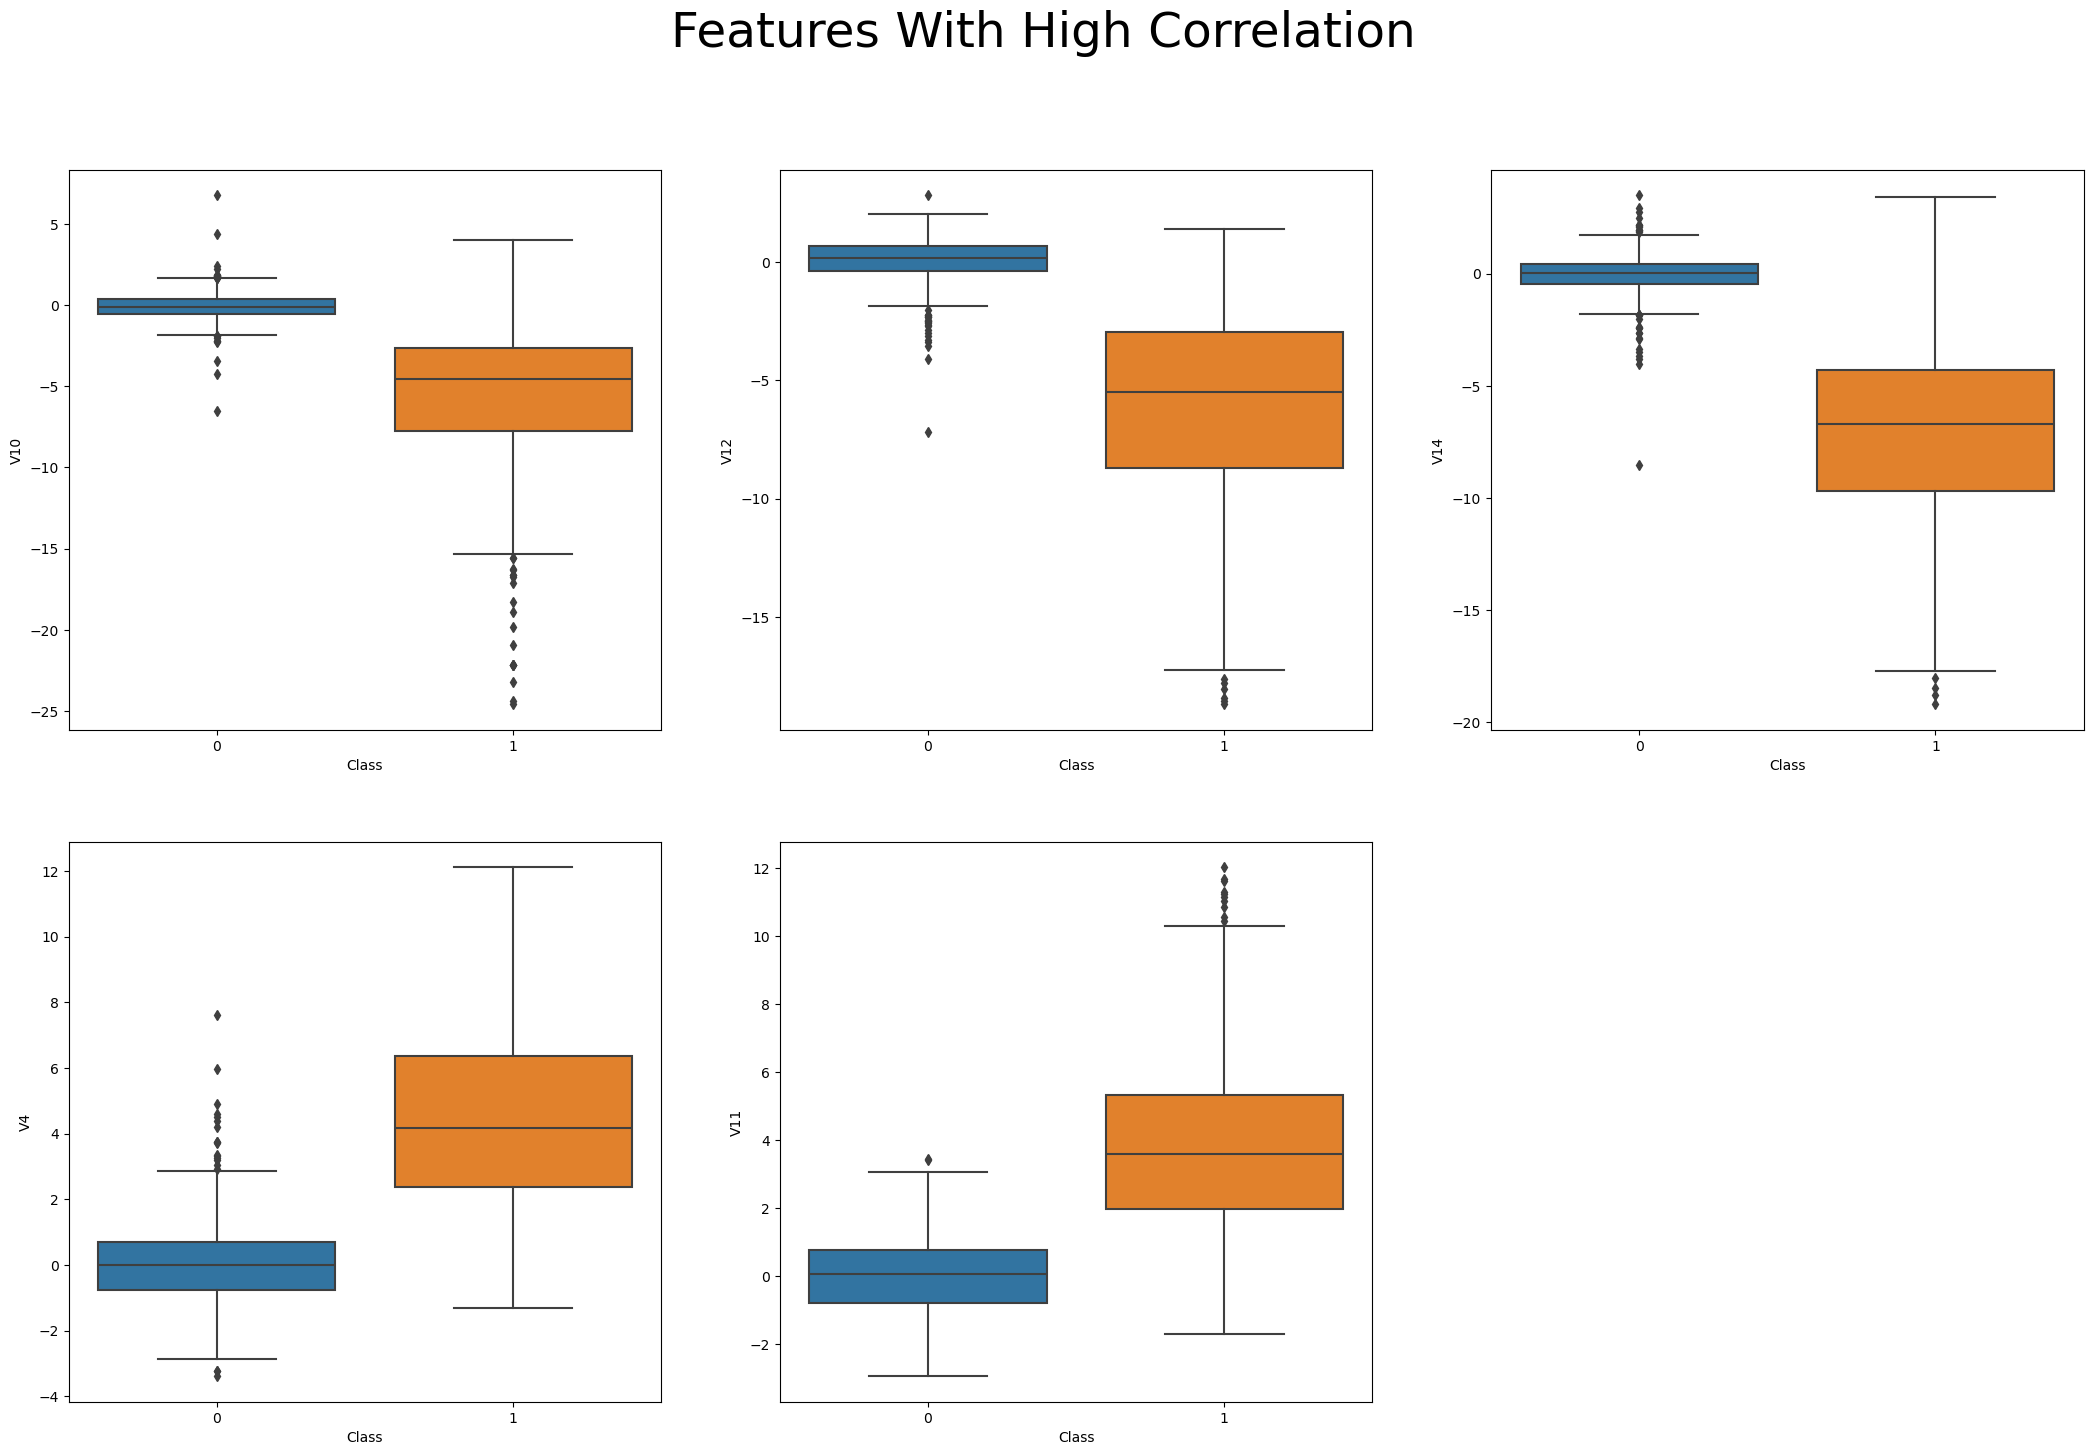

In [65]:
#visualizing the features with high correlation
f, axes = plt.subplots(nrows=2, ncols=3, figsize=(26,16))
f.suptitle('Features With High Correlation', size=35)
sns.boxplot(x="Class", y="V10", data=under_sample, ax=axes[0,0])
sns.boxplot(x="Class", y="V12", data=under_sample, ax=axes[0,1])
sns.boxplot(x="Class", y="V14", data=under_sample, ax=axes[0,2])
sns.boxplot(x="Class", y="V4", data=under_sample, ax=axes[1,0])
sns.boxplot(x="Class", y="V11", data=under_sample, ax=axes[1,1])
f.delaxes(axes[1,2])

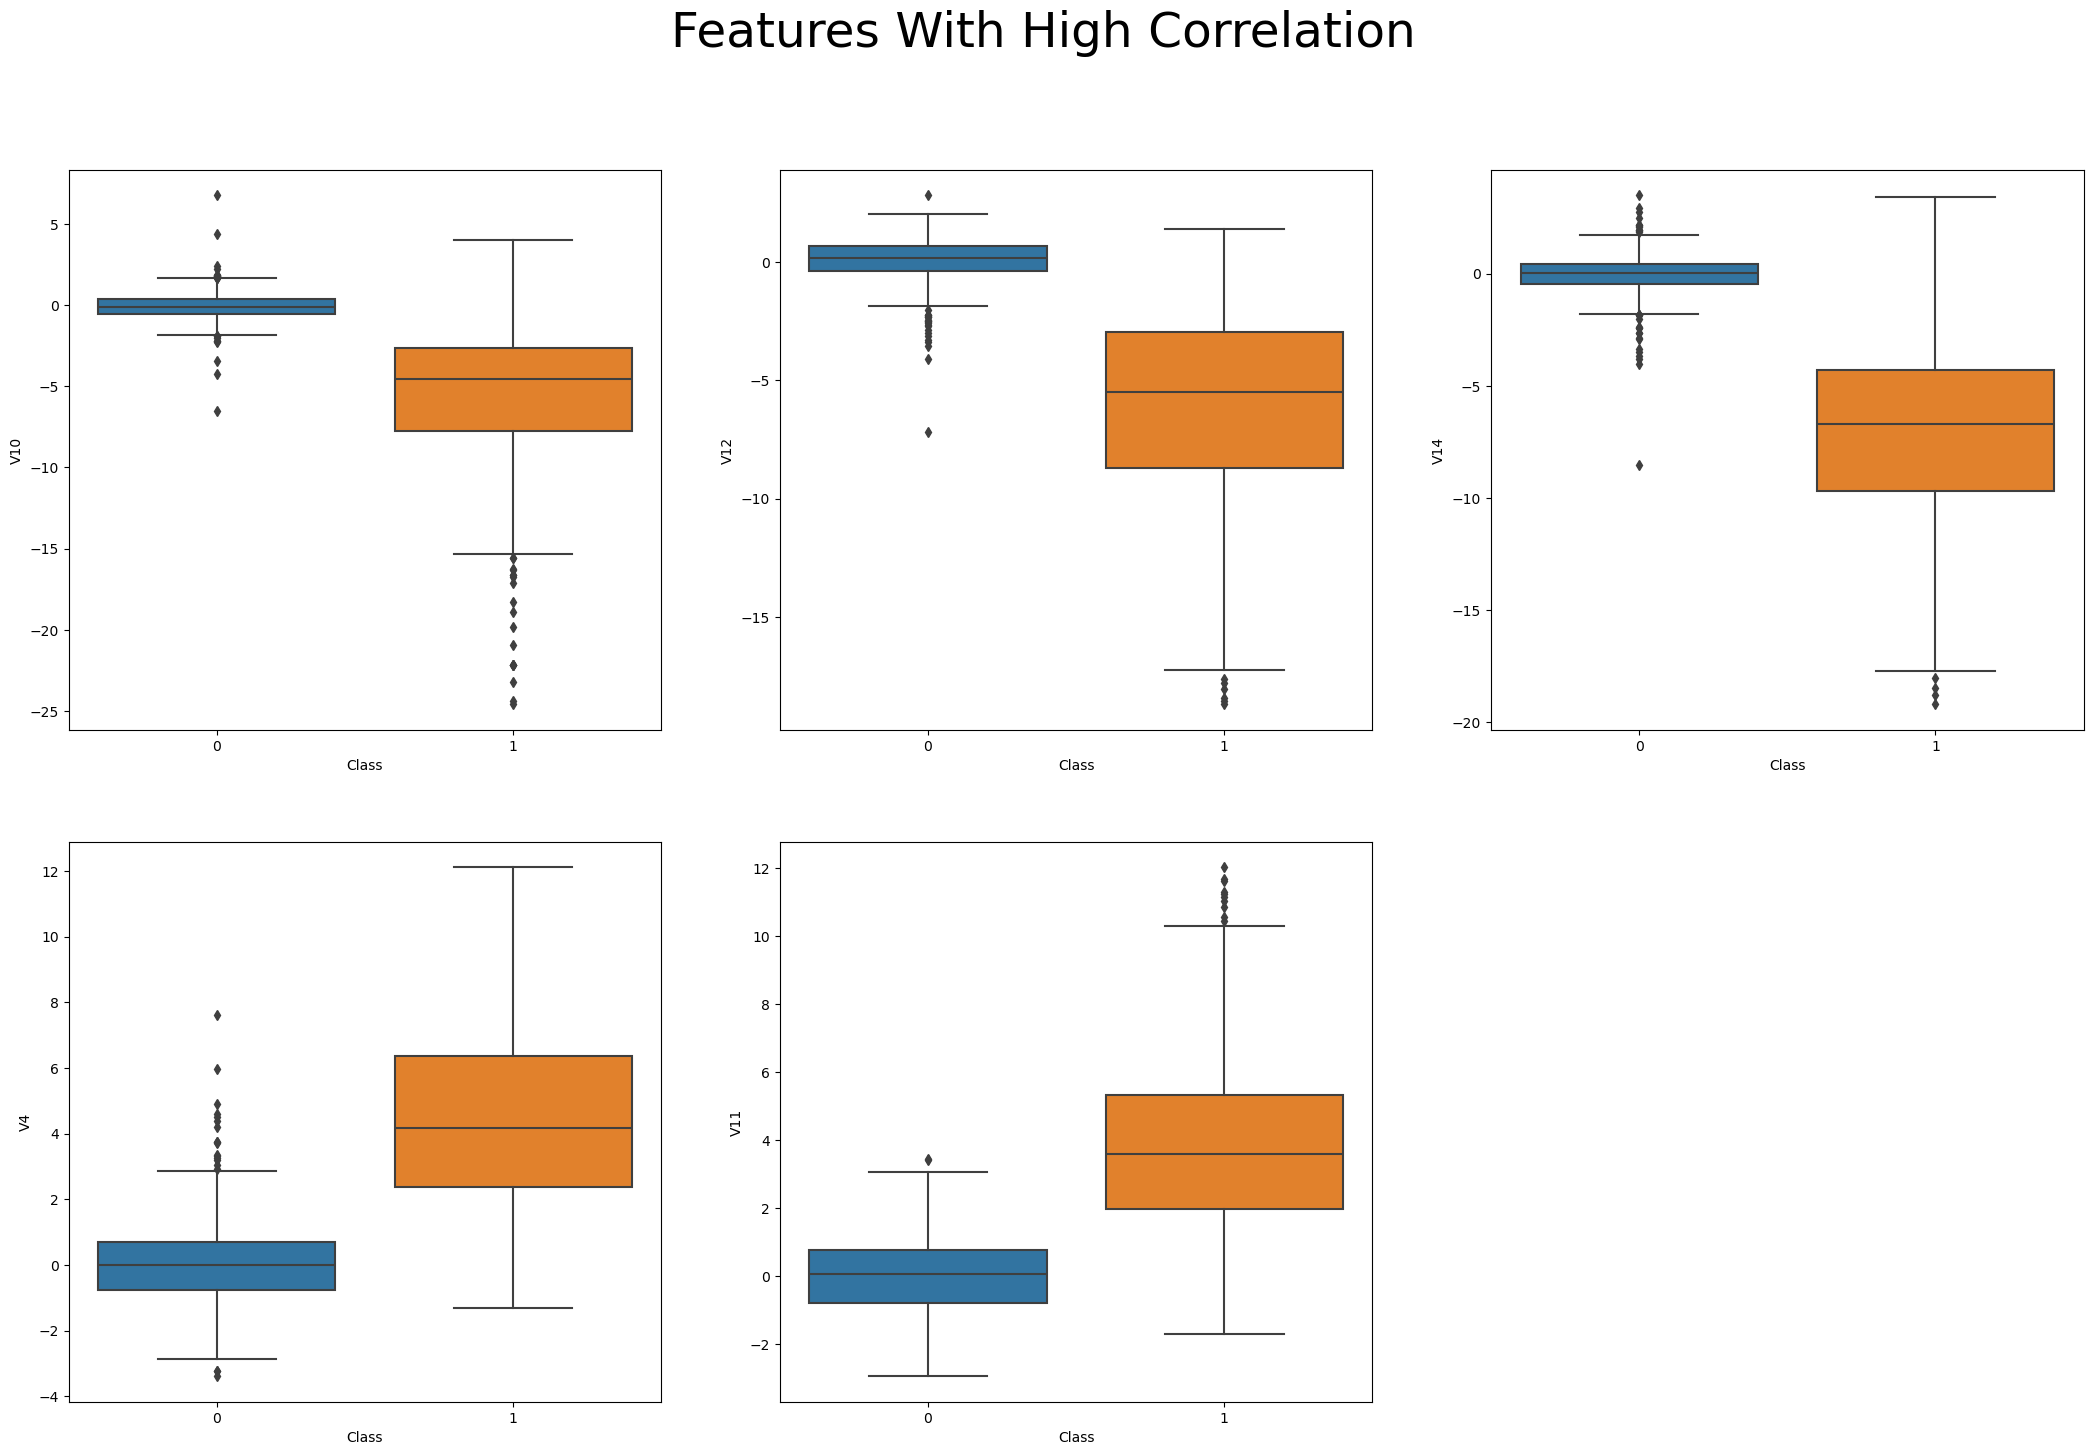

In [67]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Giả sử bạn đã đọc dữ liệu từ file CSV
# under_sample = pd.read_csv('duong_dan_den_file_goc.csv')

# Tạo các biểu đồ boxplot với màu sắc xanh và đỏ
f, axes = plt.subplots(nrows=2, ncols=3, figsize=(26,16))
f.suptitle('Features With High Correlation', size=35)

# palette = {'0': 'green', '1': 'red'}  # Đặt màu sắc cho các giá trị của 'Class'

sns.boxplot(x="Class", y="V10", data=under_sample, ax=axes[0,0])
sns.boxplot(x="Class", y="V12", data=under_sample, ax=axes[0,1])
sns.boxplot(x="Class", y="V14", data=under_sample, ax=axes[0,2])
sns.boxplot(x="Class", y="V4", data=under_sample, ax=axes[1,0])
sns.boxplot(x="Class", y="V11", data=under_sample, ax=axes[1,1])

# Loại bỏ ô trống cuối cùng
f.delaxes(axes[1,2])

# Lưu biểu đồ dưới dạng file ảnh
plt.savefig('high_correlation_features_boxplot.png')

# Hiển thị biểu đồ
plt.show()


Boxplots cung cấp cho chúng tôi trực giác tốt về việc liệu chúng tôi có cần lo lắng về các ngoại lệ hay không vì tất cả các giao dịch nằm ngoài 1,5 lần IQR (Phạm vi giữa các phần tư) thường được coi là ngoại lệ. Tuy nhiên, việc loại bỏ tất cả các giao dịch nằm ngoài 1,5 lần IQR sẽ làm giảm đáng kể kích thước dữ liệu đào tạo, vốn không lớn lắm. Vì vậy, tôi quyết định chỉ tập trung vào các ngoại lệ cực đoan nằm ngoài 2,5 lần IQR.

In [68]:
under_sample.shape

(984, 30)

###### Removing extreme outliers

In [69]:
v14_fraud = under_sample['V14'].loc[under_sample['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
v14_iqr = q75 - q25
v14_cut_off = v14_iqr * 2.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
under_sample= under_sample.drop(under_sample[(under_sample['V14'] > v14_upper) | (under_sample['V14'] < v14_lower)].index)


In [70]:
v12_fraud = under_sample['V12'].loc[under_sample['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
v12_iqr = q75 - q25
v12_cut_off = v12_iqr * 2.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
under_sample= under_sample.drop(under_sample[(under_sample['V12'] > v12_upper) | (under_sample['V12'] < v12_lower)].index)


In [71]:
v10_fraud = under_sample['V10'].loc[under_sample['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
v10_iqr = q75 - q25
v10_cut_off = v10_iqr * 2.5
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
under_sample= under_sample.drop(under_sample[(under_sample['V10'] > v10_upper) | (under_sample['V10'] < v10_lower)].index)


In [72]:
v4_fraud = under_sample['V4'].loc[under_sample['Class'] == 1].values
q25, q75 = np.percentile(v4_fraud, 25), np.percentile(v4_fraud, 75)
v4_iqr = q75 - q25
v4_cut_off = v4_iqr * 2.5
v4_lower, v4_upper = q25 - v4_cut_off, q75 + v4_cut_off
under_sample= under_sample.drop(under_sample[(under_sample['V4'] > v4_upper) | (under_sample['V4'] < v4_lower)].index)

In [73]:
v11_fraud = under_sample['V11'].loc[under_sample['Class'] == 1].values
q25, q75 = np.percentile(v11_fraud, 25), np.percentile(v11_fraud, 75)
v11_iqr = q75 - q25
v11_cut_off = v11_iqr * 2.5
v11_lower, v11_upper = q25 - v11_cut_off, q75 + v11_cut_off
under_sample= under_sample.drop(under_sample[(under_sample['V11'] > v11_upper) | (under_sample['V11'] < v11_lower)].index)

In [74]:
under_sample.shape

(976, 30)

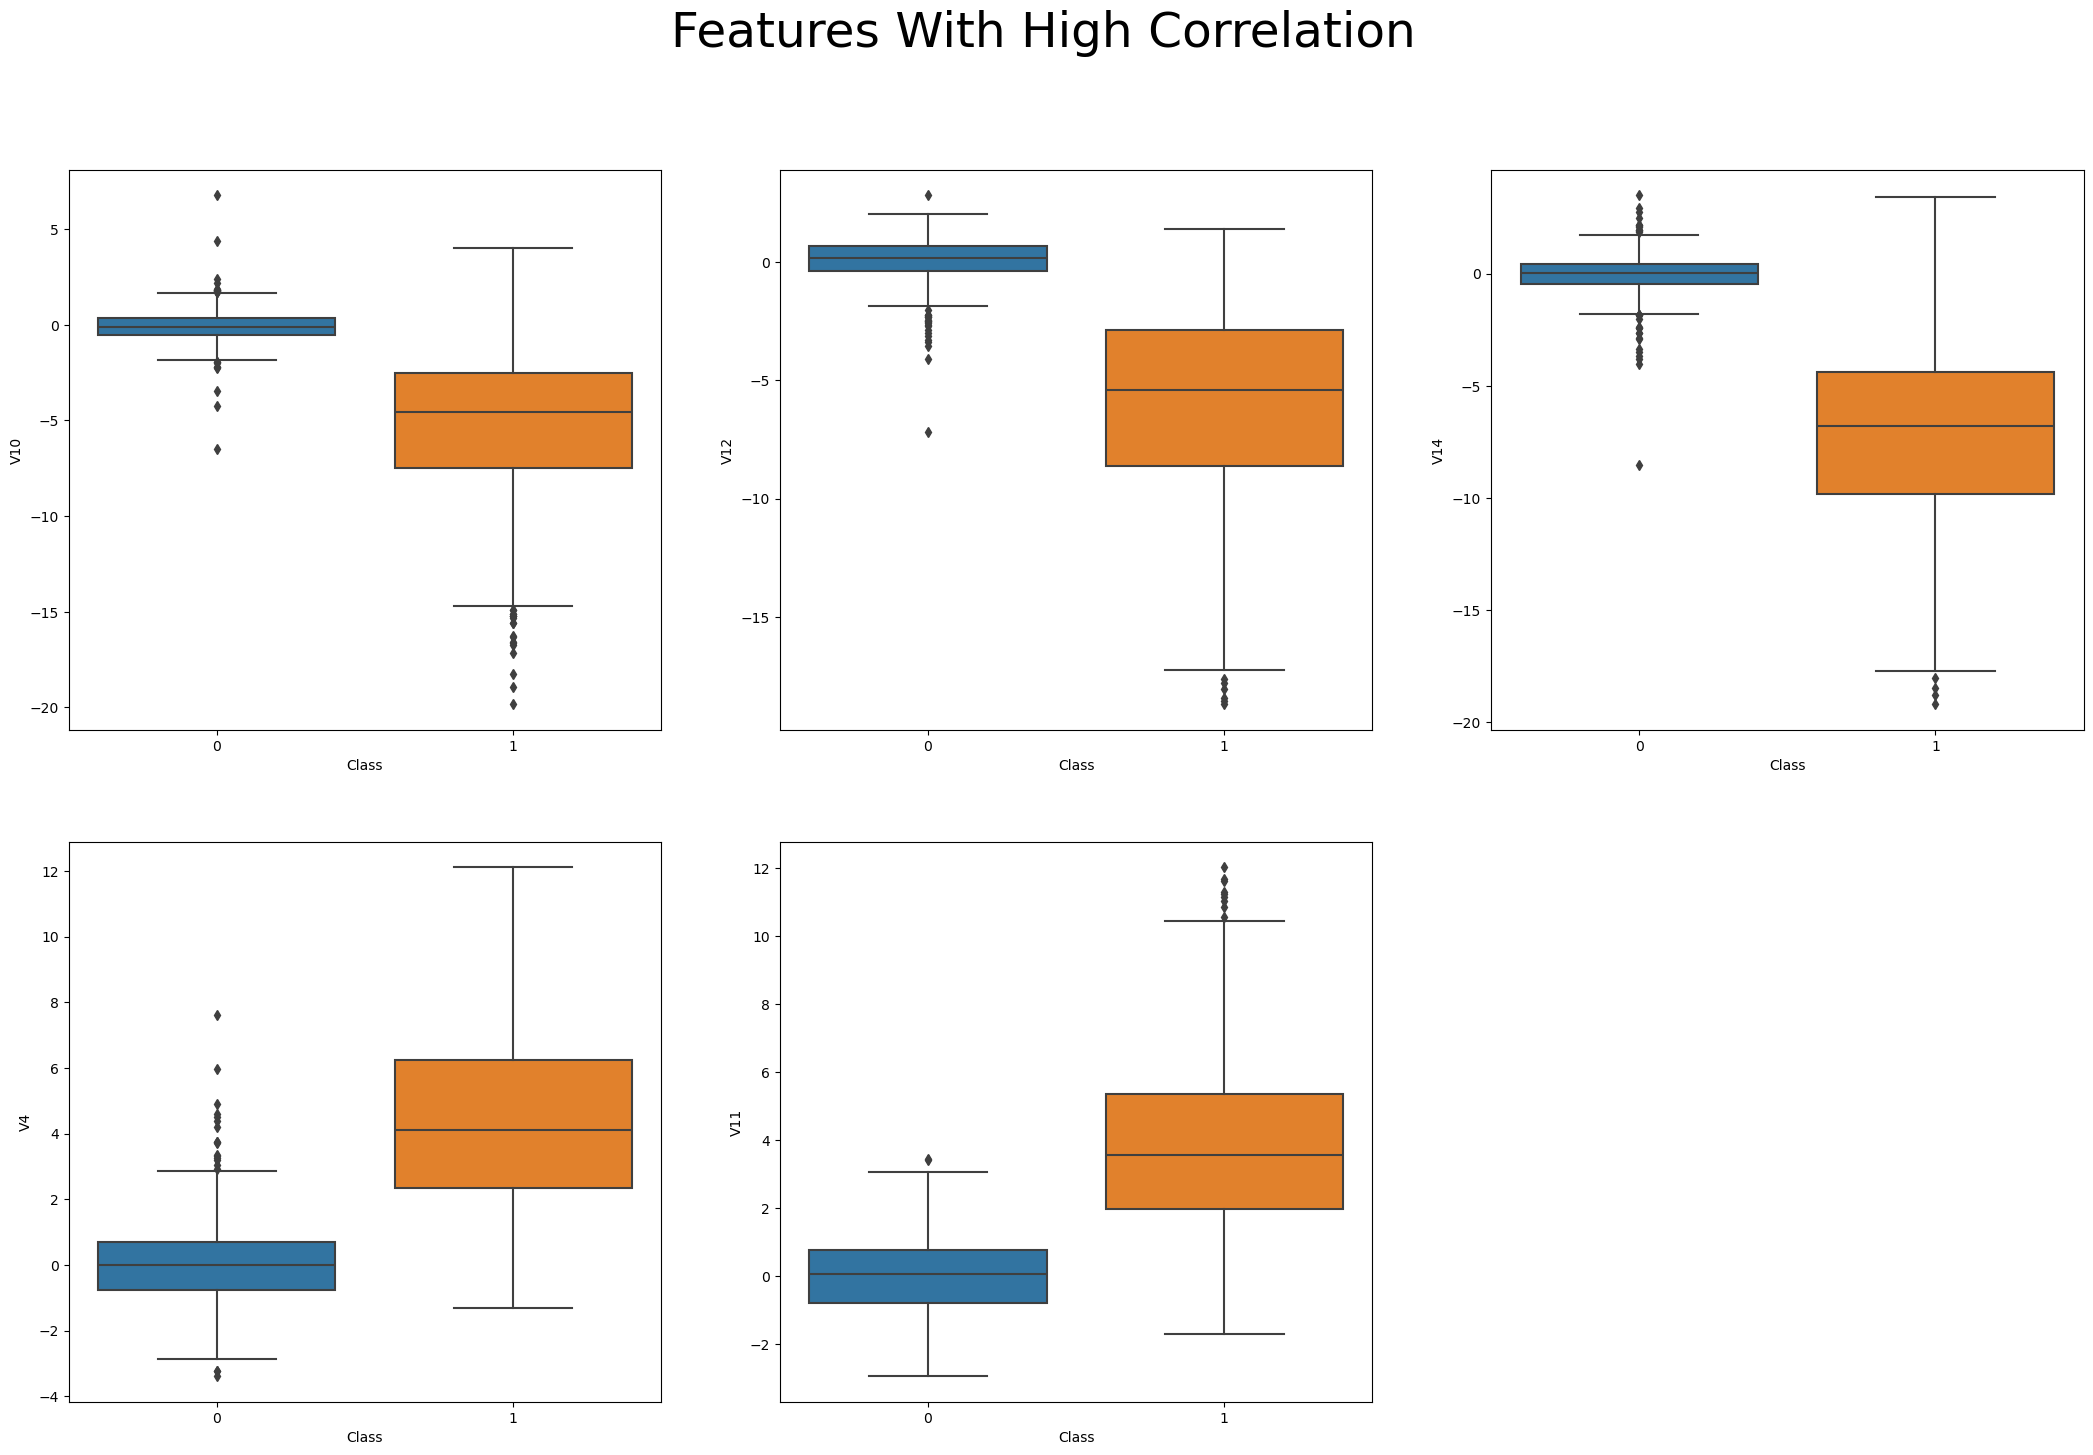

In [75]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Giả sử bạn đã đọc dữ liệu từ file CSV
# under_sample = pd.read_csv('duong_dan_den_file_goc.csv')

# Tạo các biểu đồ boxplot với màu sắc xanh và đỏ
f, axes = plt.subplots(nrows=2, ncols=3, figsize=(26,16))
f.suptitle('Features With High Correlation', size=35)

# palette = {'0': 'green', '1': 'red'}  # Đặt màu sắc cho các giá trị của 'Class'

sns.boxplot(x="Class", y="V10", data=under_sample, ax=axes[0,0])
sns.boxplot(x="Class", y="V12", data=under_sample, ax=axes[0,1])
sns.boxplot(x="Class", y="V14", data=under_sample, ax=axes[0,2])
sns.boxplot(x="Class", y="V4", data=under_sample, ax=axes[1,0])
sns.boxplot(x="Class", y="V11", data=under_sample, ax=axes[1,1])

# Loại bỏ ô trống cuối cùng
f.delaxes(axes[1,2])

# Lưu biểu đồ dưới dạng file ảnh
plt.savefig('high_correlation_features_boxplot.png')

# Hiển thị biểu đồ
plt.show()


##### Sau khi loại bỏ các ngoại lệ, khung dữ liệu mẫu của chúng tôi giảm xuống còn


Tôi đã cố gắng chạy sổ ghi chép này mà không loại bỏ các ngoại lệ và sau khi loại bỏ các ngoại lệ nhưng tôi nhận được kết quả tốt hơn trước khi loại bỏ các ngoại lệ. Trước khi nghĩ đến việc loại bỏ các ngoại lệ, cần có đủ bằng chứng cho thấy những quan sát này là các ngoại lệ thực tế. Trước khi loại bỏ các ngoại lệ. Việc này phải được thực hiện bằng phân tích thống kê chuyên sâu để đảm bảo rằng những quan sát này là các ngoại lệ thực tế vì các phương pháp ML khác nhau được sử dụng để phát hiện gian lận đều dựa trên việc phát hiện bất thường và chúng coi các ngoại lệ cực đoan đó là gian lận. Vì vậy, bằng cách xóa nó, chúng tôi xóa những quan sát quan trọng nhất có khả năng gian lận cao hơn


##### Tách theo khung dữ liệu được lấy mẫu


In [76]:
X_under = under_sample.loc[:,under_sample.columns != 'Class']
y_under = under_sample.loc[:,under_sample.columns == 'Class']
X_under_train, X_under_test, y_under_train, y_under_test = train_test_split(X_under,y_under,test_size = 0.3, random_state = 0)

### 3] Logistic regression with C=0.01

In [78]:
lr_under_C1 = LogisticRegression(C=0.01)
lr_under_C1.fit(X_under_train,y_under_train)

LogisticRegression(C=0.01)

Logistic Regression Cross Validation Score(Recall):  87.14%
Recall: 0.8775510204081632
Log Loss: 0.35688038537028344
Precision: 0.13479623824451412
Accurcay: 0.9900986622660721
AUC:  0.933921824216462
F1 Score: 0.23369565217391305
Confusion matrix:
 [[84468   828]
 [   18   129]]


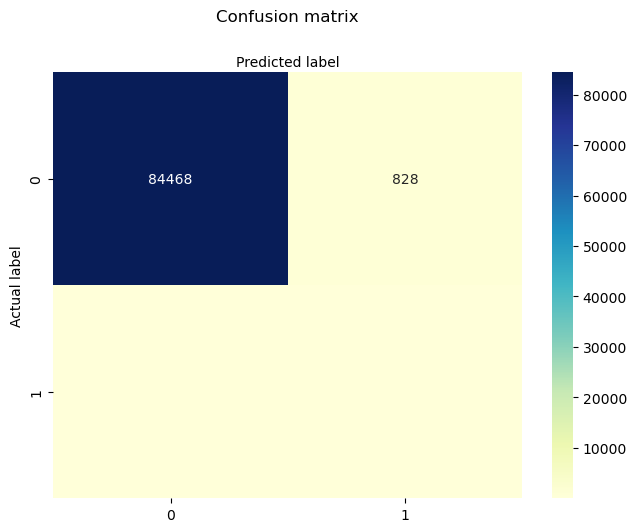

In [79]:
# Prediction on original dataframe
y_pred_full_model1 = lr_under_C1.predict(X_test)
cross_validation_metrics(lr_under_C1,X_under_train,y_under_train)
print_accuracy_metrics(y_test,y_pred_full_model1)

### 4] Logistic regression with C=0.1

In [80]:
lr_under_C2 = LogisticRegression(C=0.1)
lr_under_C2.fit(X_under_train,y_under_train)

LogisticRegression(C=0.1)

Logistic Regression Cross Validation Score(Recall):  89.78%
Recall: 0.9183673469387755
Log Loss: 0.7453991027769394
Precision: 0.07142857142857142
Accurcay: 0.9793195463642428
AUC:  0.9488959694738895
F1 Score: 0.1325478645066274
Confusion matrix:
 [[83541  1755]
 [   12   135]]


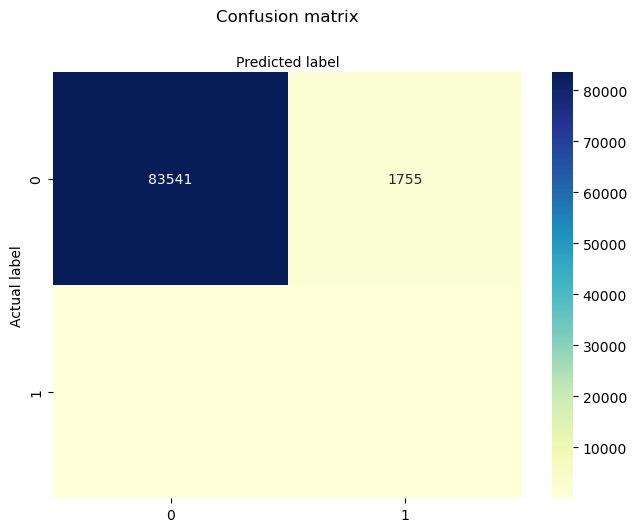

In [81]:
# Prediction on original dataset
y_pred_full_model2 = lr_under_C2.predict(X_test)
cross_validation_metrics(lr_under_C2,X_under_train,y_under_train)
print_accuracy_metrics(y_test,y_pred_full_model2)

### 5] Logistic regression with C=1

In [82]:
lr_under_C3 = LogisticRegression(C=1)
lr_under_C3.fit(X_under_train,y_under_train)

LogisticRegression(C=1)

Logistic Regression Cross Validation Score(Recall):  89.49%
Recall: 0.9183673469387755
Log Loss: 1.0714848449651535
Precision: 0.050694705219677054
Accurcay: 0.9702725793804057
AUC:  0.9443646901641917
F1 Score: 0.09608540925266904
Confusion matrix:
 [[82768  2528]
 [   12   135]]


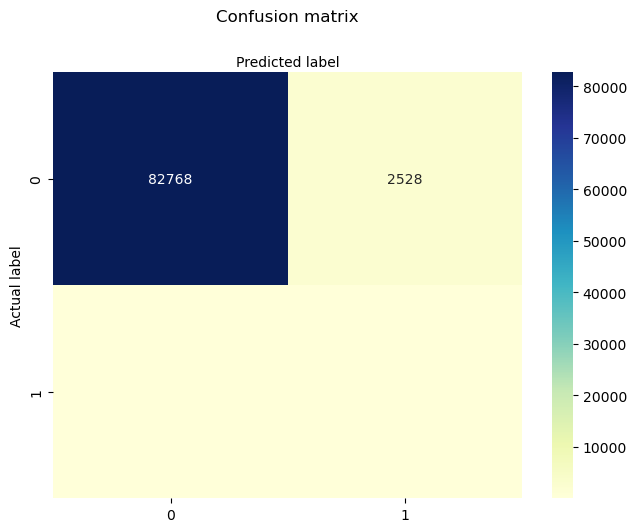

In [83]:
# Prediction on original dataset
y_pred_full_model3 = lr_under_C3.predict(X_test)
cross_validation_metrics(lr_under_C3,X_under_train,y_under_train)
print_accuracy_metrics(y_test,y_pred_full_model3)

### 6] Logistic regreesion with C=10

In [84]:
lr_under_C4 = LogisticRegression(C=10)
lr_under_C4.fit(X_under_train,y_under_train)

LogisticRegression(C=10)

Logistic Regression Cross Validation Score(Recall):  89.78%
Recall: 0.9183673469387755
Log Loss: 1.1714619742000907
Precision: 0.04655172413793104
Accurcay: 0.9674988003698372
AUC:  0.9429754104793294
F1 Score: 0.08861174926156876
Confusion matrix:
 [[82531  2765]
 [   12   135]]


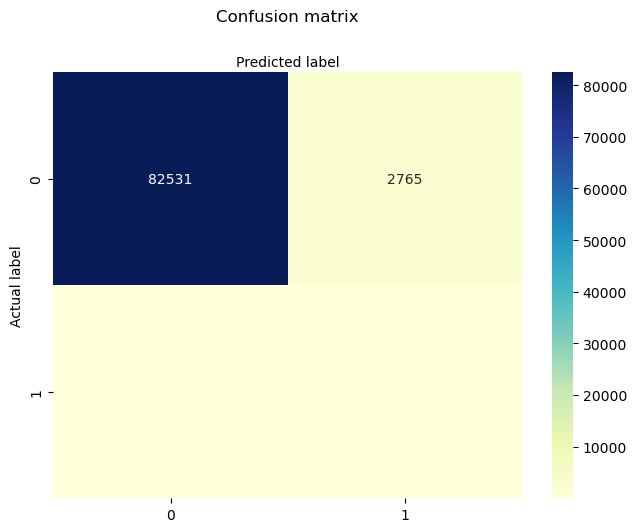

In [85]:
# Prediction on original dataset
y_pred_full_model4 = lr_under_C4.predict(X_test)
cross_validation_metrics(lr_under_C4,X_under_train,y_under_train)
print_accuracy_metrics(y_test,y_pred_full_model4)

### 7] Decision Tree Classifier

In [86]:
DecisionTreeClassifier= DecisionTreeClassifier()
DecisionTreeClassifier.fit(X_under_train,y_under_train)

DecisionTreeClassifier()

Logistic Regression Cross Validation Score(Recall):  87.74%
Recall: 0.9659863945578231
Log Loss: 3.5481334767724024
Precision: 0.016612072999532053
Accurcay: 0.9015601043970835
AUC:  0.9337177330132953
F1 Score: 0.03266244968372627
Confusion matrix:
 [[76890  8406]
 [    5   142]]


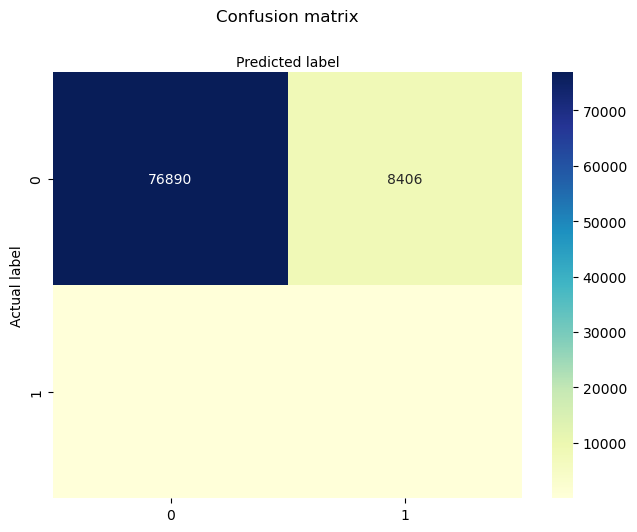

In [87]:
# Prediction on original dataset
y_pred_DecisionTree = DecisionTreeClassifier.predict(X_test)
cross_validation_metrics(DecisionTreeClassifier,X_under_train,y_under_train)
print_accuracy_metrics(y_test,y_pred_DecisionTree)

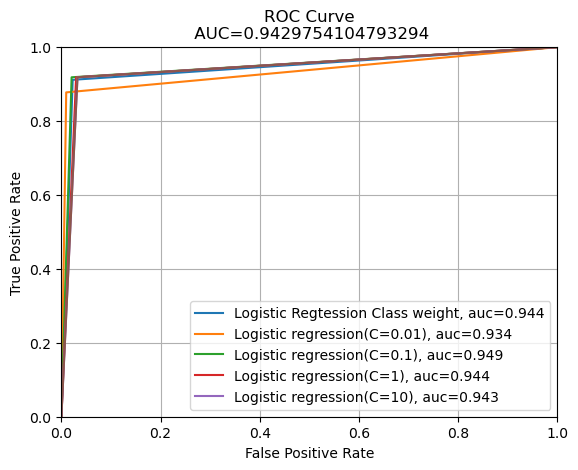

In [88]:
plt.figure(0).clf()

fpr, tpr, thresh = metrics.roc_curve(y_test, y_balanced_pred)
auc = metrics.roc_auc_score(y_test, y_balanced_pred)
plt.plot(fpr,tpr,label="Logistic Regtession Class weight, auc="+ '{0:.3f}'.format(auc))

fpr, tpr, thresh = metrics.roc_curve(y_test, y_pred_full_model1)
auc = metrics.roc_auc_score(y_test, y_pred_full_model1)
plt.plot(fpr,tpr,label="Logistic regression(C=0.01), auc="+ '{0:.3f}'.format(auc))

fpr, tpr, thresh = metrics.roc_curve(y_test, y_pred_full_model2)
auc = metrics.roc_auc_score(y_test, y_pred_full_model2)
plt.plot(fpr,tpr,label="Logistic regression(C=0.1), auc="+'{0:.3f}'.format(auc))

fpr, tpr, thresh = metrics.roc_curve(y_test, y_pred_full_model3)
auc = metrics.roc_auc_score(y_test, y_pred_full_model3)
plt.plot(fpr,tpr,label="Logistic regression(C=1), auc="+'{0:.3f}'.format(auc))

fpr, tpr, thresh = metrics.roc_curve(y_test, y_pred_full_model4)
auc = metrics.roc_auc_score(y_test, y_pred_full_model4)
plt.plot(fpr,tpr,label="Logistic regression(C=10), auc="+'{0:.3f}'.format(auc))

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC Curve\n AUC={auc}'.format(auc = auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.legend(loc="lower right")

Rõ ràng, việc cố gắng tăng khả năng thu hồi có xu hướng làm giảm độ chính xác. Tuy nhiên, trong trường hợp của chúng tôi, nếu chúng tôi dự đoán rằng một giao dịch là gian lận và hóa ra không phải như vậy thì đó không phải là vấn đề lớn so với điều ngược lại.
